## Predicting expression across tissues

Some cell population are present in multiple tissues. Here, we use different models to predict cell population-specific expression across tissues or across cell populations (see Figure 3A for the set up). In this notebook, we reproduce Figure 3B, S11 and S12.

In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

matplotlib.rcParams['pdf.fonttype'] = 42

Before running these cells, run the functions at the bottom of the notebook.

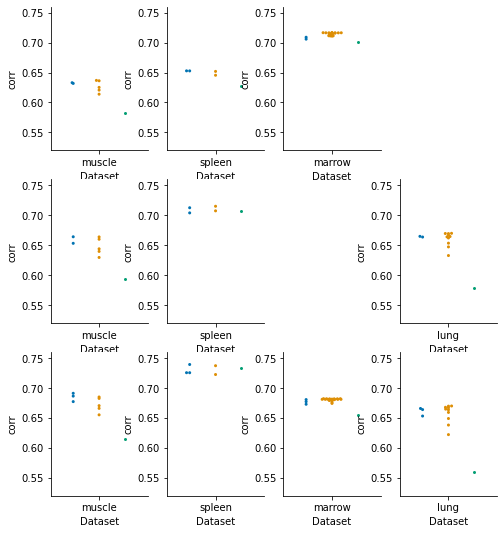

In [6]:
#Figure 3B
protocol = 'FACS_SM2'
tissue_order = ['muscle', 'spleen', 'marrow', 'lung']
ymin = 0.52
ymax = 0.76

fig, axes = plt.subplots(3,4, figsize=(8,9))

ct = 'macrophage'
tissues = ['spleen','muscle', 'marrow']
fig, axes = generate_plots(ct, tissues, protocol, fig, axes, 0, tissue_order, ymin, ymax)

ct = 'T cell'
tissues = ['lung', 'spleen', 'muscle']
fig, axes = generate_plots(ct, tissues, protocol, fig, axes, 1, tissue_order, ymin, ymax)

ct = 'B cell'
tissues = ['lung', 'spleen', 'muscle', 'marrow']
fig, axes = generate_plots(ct, tissues, protocol, fig, axes, 2, tissue_order, ymin, ymax)
plt.show()

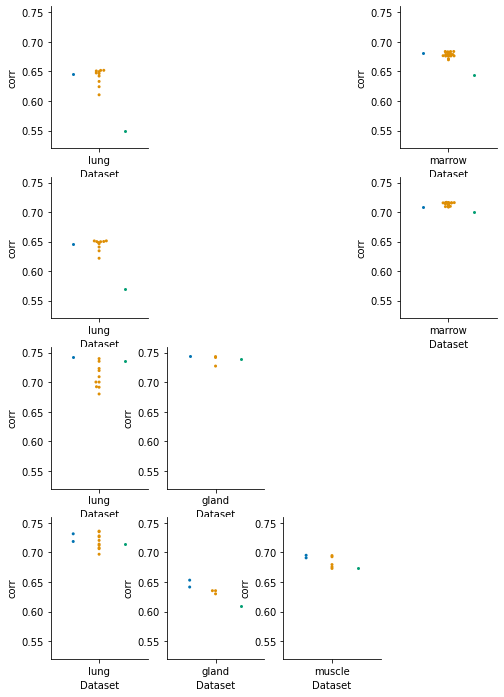

In [7]:
#Figure S11
protocol = 'FACS_SM2'
tissue_order = ['lung', 'gland', 'muscle', 'marrow']
ymin = 0.52
ymax = 0.76

fig, axes = plt.subplots(4,4, figsize=(8,12))

ct = 'natural killer cell'
tissues = ['lung', 'marrow']
fig, axes = generate_plots(ct, tissues, protocol, fig, axes, 0, tissue_order, ymin, ymax)

ct = 'monocyte'
tissues = ['lung', 'marrow']
fig, axes = generate_plots(ct, tissues, protocol, fig, axes, 1, tissue_order, ymin, ymax)

ct = 'stromal cell'
tissues = ['gland', 'lung']
fig, axes = generate_plots(ct, tissues, protocol, fig, axes, 2, tissue_order, ymin, ymax)

ct = 'endothelial cell'
tissues = ['gland', 'muscle', 'lung']
fig, axes = generate_plots(ct, tissues, protocol, fig, axes, 3, tissue_order, ymin, ymax)



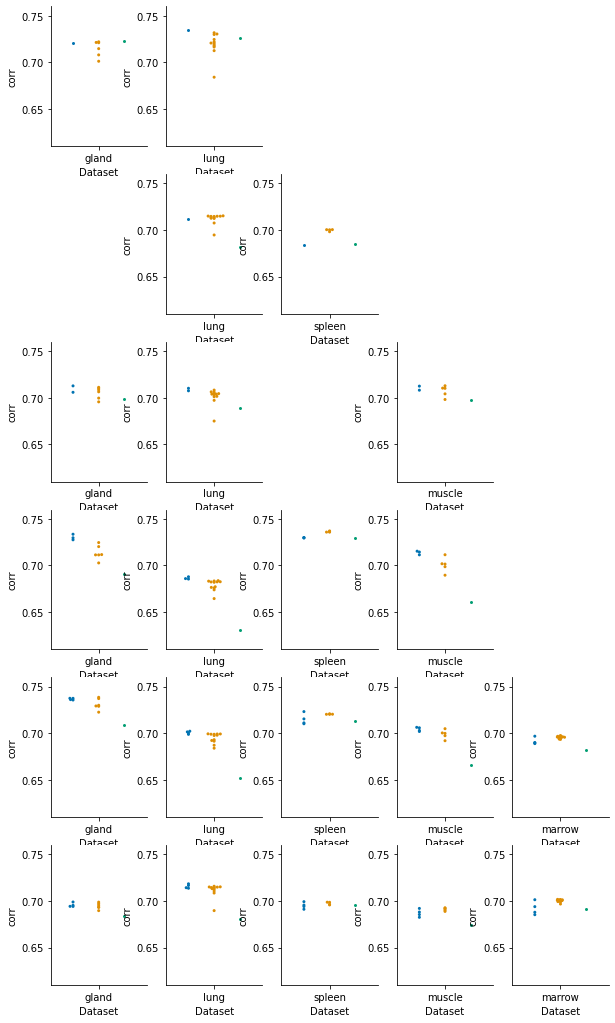

In [8]:
#Figure S12
protocol = '10X'
tissue_order = ['gland', 'lung', 'spleen', 'muscle', 'marrow']
ymin = 0.61
ymax = 0.76

fig, axes = plt.subplots(6,5, figsize=(10,18))
ct = 'stromal cell'
tissues = ['gland', 'lung']
fig, axes = generate_plots(ct, tissues, protocol, fig, axes, 0, tissue_order, ymin, ymax)

ct = 'natural killer cell'
tissues = ['lung', 'spleen']
fig, axes = generate_plots(ct, tissues, protocol, fig, axes, 1, tissue_order, ymin, ymax)

ct = 'endothelial cell'
tissues = ['gland', 'lung', 'muscle']
fig, axes = generate_plots(ct, tissues, protocol, fig, axes, 2, tissue_order, ymin, ymax)

ct = 'B cell'
tissues = ['gland', 'lung', 'spleen', 'muscle']
fig, axes = generate_plots(ct, tissues, protocol, fig, axes, 3, tissue_order, ymin, ymax)

ct = 'T cell'
tissues = ['gland', 'lung', 'spleen', 'muscle', 'marrow']
fig, axes = generate_plots(ct, tissues, protocol, fig, axes, 4, tissue_order, ymin, ymax)

ct = 'macrophage'
tissues = ['gland', 'lung', 'spleen', 'muscle', 'marrow']
fig, axes = generate_plots(ct, tissues, protocol, fig, axes, 5, tissue_order, ymin, ymax)


In [2]:
def generate_plots(ct, tissues, protocol, fig, axes, row, tissue_order, ymin, ymax):
    
    # Here, we will save all results
    all_corr = pd.DataFrame(data=np.zeros((0,4)),
                            columns=['Dataset','corr','model_used','Type'])
    
    # Performance of same cell population, different tissue
    for t in tissues:
        for t2 in tissues:
            if t != t2:
                corr = cp_diffdataset(t, t2, ct, protocol)
                all_corr = all_corr.append(corr)
                
    
    # Performance of different cell population, same tissue
    for t in tissues:
        corr = cp_samedataset(t, ct, protocol)
        all_corr = pd.concat([all_corr,corr])
    
    # Performance of the tissue-specific model
    for t in tissues:
        corr = tissue(t, ct, protocol)
        all_corr = pd.concat([all_corr,corr])
    
    # Make the subplots
    for i, t in enumerate(tissue_order):
        sub_corr = all_corr[all_corr['Dataset'] == t]
        
        # If combination of cell pop and tissue doesn't exist --> empty plot
        if(len(sub_corr) == 0):
            axes[row,i].axis('off')
            continue;
        
        g = sns.swarmplot(ax = axes[row,i], data=sub_corr, x='Dataset', 
                          y='corr', hue='Type', dodge=True, palette='colorblind',
                          size=3
                   )
        sns.despine()
        g.axis(ymin=ymin, ymax=ymax)
        g.get_legend().remove()

    return fig, axes

In [3]:
def cp_diffdataset(tissue_true, tissue_pred, ct, protocol):
    # Performance of models trained on the same cell population, but from a different tissue
    
    # Find index of celltype in true tissue
    filename_true = '../../Zenodo/mouse/TM_' + protocol + '/' + tissue_true + '/pseudobulk.csv'
    celltypes = np.array(pd.read_csv(filename_true, index_col=0).columns, dtype='str')
    ct_true = np.where(celltypes == ct)[0]
    
    # Find index of celltype in predicted tissue
    filename_pred = '../../Zenodo/mouse/TM_' + protocol + '/' + tissue_pred + '/pseudobulk.csv'
    celltypes = np.array(pd.read_csv(filename_pred, index_col=0).columns, dtype='str')
    ct_pred = np.where(celltypes == ct)[0]
    
    corr_folds = np.zeros((20,))
    
    for i in range(0,20):
        
        y_pred = 0
        
        file = '../../Zenodo/mouse/TM_' + protocol + '/' + tissue_true + '/cp_specific/logmean_zscore_multitask_' + str(i) + '/logs_dir' + str(0) + '/results_testdata_best.pkl'
        y = pd.read_pickle(file)
        y_true = np.asarray(y['y_true'])[:,ct_true-1]
        
        for j in range(5):
        
            file = '../../Zenodo/mouse/TM_' + protocol + '/' + tissue_pred + '/cp_specific/logmean_zscore_multitask_' + str(i) + '/logs_dir' + str(j) + '/results_testdata_best.pkl'
            y = pd.read_pickle(file)
            y_pred = y_pred + np.asarray(y['y_pred'])[:,ct_pred-1]/5
            
        x,_ = pearsonr(np.squeeze(y_pred), np.squeeze(y_true))
        corr_folds[i] = x
        
    corr = pd.DataFrame(data=np.zeros((1,4)),
                   columns=['Dataset','corr','model_used','Type'])
    corr = corr.astype({"model_used": str})

    corr['corr'] = np.median(corr_folds)
    corr['model_used'] = tissue_pred

    corr['Type']='Cell population-specific (different dataset, same cell population)'
    corr['Dataset']= tissue_true

    return corr

In [4]:
def cp_samedataset(tissue, ct, protocol):
    # Performance of models trained on a different cell population, but from the same tissue
    
    # Find index of cell pop we want to predict and index of the models used
    filename = '../../Zenodo/mouse/TM_' + protocol + '/' + tissue + '/pseudobulk.csv'
    celltypes = np.array(pd.read_csv(filename, index_col=0).columns, dtype='str')
    ct_yes = np.where(celltypes == ct)[0]
    ct_no = np.where(celltypes != ct)[0]
    ct_no = ct_no[1:]
    
    corr_folds = np.zeros((20,len(ct_no)))
    
    for i in range(0,20):
        
        y_pred = 0
        
        for j in range(5):
        
            file = '../../Zenodo/mouse/TM_' + protocol + '/' + tissue + '/cp_specific/logmean_zscore_multitask_' + str(i) + '/logs_dir' + str(j) + '/results_testdata_best.pkl'
            y = pd.read_pickle(file)
            y_pred = y_pred + np.asarray(y['y_pred'])/5
            y_true = np.asarray(y['y_true'])
        
        for k,p in enumerate(np.transpose(y_pred[:,ct_no-1])):
            x,_ = pearsonr(p, y_true[:,ct_yes-1])
            corr_folds[i,k] = x
    
    corr = pd.DataFrame(data=np.zeros((len(ct_no),4)),
                       columns=['Dataset','corr','model_used','Type'])
    corr = corr.astype({"model_used": str})
        
    for i in range(len(ct_no)):
        corr['corr'].values[i] = np.median(corr_folds[:,i])
        corr['model_used'].values[i] = celltypes[ct_no[i]]
    
    corr['Type']='Cell population-specific (same dataset, different cell population)'
    corr['Dataset']=tissue
    
    return corr

In [5]:
def tissue(tissue, ct, protocol):
    # Performance of the tissue-specific model on that cell population

    # Find index of the cell population
    filename = '../../Zenodo/mouse/TM_' + protocol + '/' + tissue + '/pseudobulk.csv'
    celltypes = np.array(pd.read_csv(filename, index_col=0).columns, dtype='str')
    ct_yes = np.where(celltypes == ct)[0]
    corr_folds = np.zeros((20,))
    
    for i in range(0,20):
        
        y_pred = 0
        
        # True expression
        file = '../../Zenodo/mouse/TM_' + protocol + '/' + tissue + '/cp_specific/logmean_zscore_multitask_' + str(i) + '/logs_dir' + str(0) + '/results_testdata_best.pkl'
        y = pd.read_pickle(file)
        y_true = np.asarray(y['y_true'])

        for j in range(5):

            # Predicted expression 
            file = '../../Zenodo/mouse/TM_' + protocol + '/' + tissue + '/tissue_specific/logmean_zscore_All_' + str(i) + '/logs_dir' + str(j) + '/results_testdata_best.pkl'
            y = pd.read_pickle(file)
            y_pred = y_pred + np.asarray(y['y_pred'])/5
        
        x,_ = pearsonr(y_pred, y_true[:,ct_yes-1])
        corr_folds[i] = x
    
    
    corr = pd.DataFrame(data=np.zeros((1,4)),
                       columns=['Dataset','corr','model_used','Type'])
    corr = corr.astype({"model_used": str})

    corr['corr'] = np.median(corr_folds)
    corr['model_used'] = 'tissue-specific'
    
    corr['Type']='Tissue-specific (same dataset)'
    corr['Dataset']=tissue
    
    return corr